In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("student_performance.csv")

In [3]:
print(df.head())

   Hours_Studied  Previous_Scores Extracurricular  Sleep_Hours  \
0              2               40              No            6   
1              5               60             Yes            7   
2              8               85              No            8   
3              1               35              No            5   
4              6               75             Yes            7   

  Internet_Access  Attendance Performance  
0             Yes          70         Low  
1             Yes          80      Medium  
2             Yes          90        High  
3              No          60         Low  
4             Yes          85        High  


In [4]:
print(df.describe(include="all"))

        Hours_Studied  Previous_Scores Extracurricular  Sleep_Hours  \
count       20.000000        20.000000              20    20.000000   
unique            NaN              NaN               2          NaN   
top               NaN              NaN              No          NaN   
freq              NaN              NaN              10          NaN   
mean         4.600000        60.650000             NaN     6.500000   
std          2.414866        18.345443             NaN     1.051315   
min          1.000000        30.000000             NaN     5.000000   
25%          2.750000        46.500000             NaN     6.000000   
50%          4.500000        59.000000             NaN     6.500000   
75%          6.250000        75.750000             NaN     7.000000   
max          9.000000        92.000000             NaN     8.000000   

       Internet_Access  Attendance Performance  
count               20   20.000000          20  
unique               2         NaN           3  


In [5]:
print("Missing values:\n", df.isna().sum())

Missing values:
 Hours_Studied      0
Previous_Scores    0
Extracurricular    0
Sleep_Hours        0
Internet_Access    0
Attendance         0
Performance        0
dtype: int64


In [8]:
for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())


In [9]:
for col in df.select_dtypes(include=["object"]).columns:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].mode()[0])

In [11]:
X = df.drop("Performance", axis=1)
y = df["Performance"]

In [13]:
from sklearn.preprocessing import OneHotEncoder

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Use sparse_output for sklearn >=1.2, fallback for older versions
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:  # for older sklearn
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

if cat_cols:
    X_cat = pd.DataFrame(
        ohe.fit_transform(X[cat_cols]),
        columns=ohe.get_feature_names_out(cat_cols),
        index=X.index
    )
    X_num = X.drop(columns=cat_cols)
    X = pd.concat([X_num, X_cat], axis=1)
else:
    X = X.copy()


In [14]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [15]:
print(export_text(clf, feature_names=list(X.columns), max_depth=5))

|--- Hours_Studied <= 3.50
|   |--- class: Low
|--- Hours_Studied >  3.50
|   |--- Previous_Scores <= 70.00
|   |   |--- class: Medium
|   |--- Previous_Scores >  70.00
|   |   |--- class: High



In [16]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
Confusion Matrix:
 [[2 0 0]
 [0 2 0]
 [0 0 2]]
Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00         2
         Low       1.00      1.00      1.00         2
      Medium       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [17]:
for depth in [None, 3, 5, 7, 9]:
    for crit in ["gini", "entropy"]:
        model = DecisionTreeClassifier(max_depth=depth, criterion=crit, random_state=42)
        model.fit(X_train, y_train)
        y_val = model.predict(X_test)
        acc = accuracy_score(y_test, y_val)
        print(f"Depth={depth}, Criterion={crit}, Accuracy={acc:.3f}")



Depth=None, Criterion=gini, Accuracy=1.000
Depth=None, Criterion=entropy, Accuracy=1.000
Depth=3, Criterion=gini, Accuracy=1.000
Depth=3, Criterion=entropy, Accuracy=1.000
Depth=5, Criterion=gini, Accuracy=1.000
Depth=5, Criterion=entropy, Accuracy=1.000
Depth=7, Criterion=gini, Accuracy=1.000
Depth=7, Criterion=entropy, Accuracy=1.000
Depth=9, Criterion=gini, Accuracy=1.000
Depth=9, Criterion=entropy, Accuracy=1.000


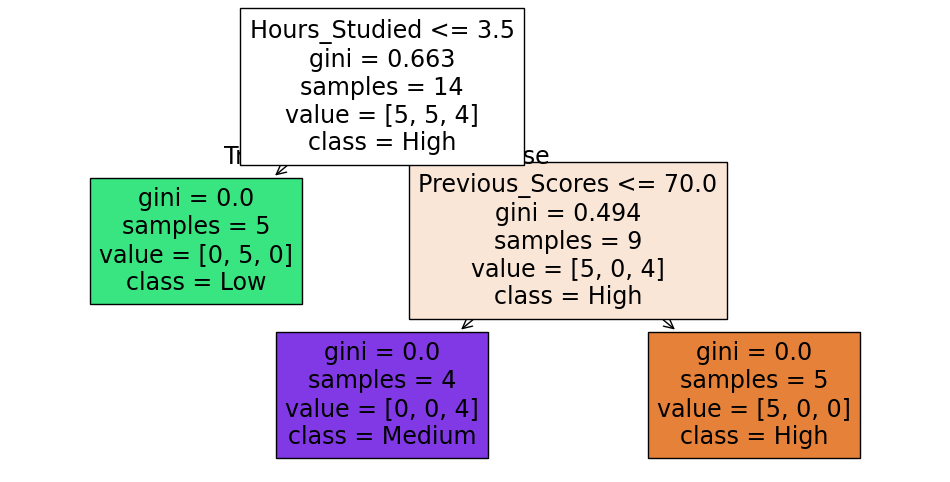

In [20]:
plt.figure(figsize=(12, 6))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=[str(c) for c in clf.classes_],  # auto-detects
    filled=True
)
plt.show()


In [21]:
# Feature importances
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": clf.feature_importances_
}).sort_values("Importance", ascending=False)

print("\nTop Features:\n", importances.head(10))


Top Features:
                Feature  Importance
0        Hours_Studied    0.521368
1      Previous_Scores    0.478632
2          Sleep_Hours    0.000000
3           Attendance    0.000000
4   Extracurricular_No    0.000000
5  Extracurricular_Yes    0.000000
6   Internet_Access_No    0.000000
7  Internet_Access_Yes    0.000000
